In [ ]:
import tensorflow as tf
import time
import shutil
import os

In [ ]:
#Since we're dealing with image files which are big files, GPU will be used for enhanced performance in terms of computations
#Using Kaggle IDE, GPU is integrated & has been activated
#Checking GPU Activation / Listing number of GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


2022-04-22 00:30:54.145306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 00:30:54.237671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 00:30:54.238424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
#display working dir
os.listdir('./')

['__notebook_source__.ipynb']

In [ ]:
#this is where the ds is stored
os.listdir('/kaggle/input/')

['foodnonfood']

In [ ]:
#importing important libs
import numpy as np #mathematical fn
import pandas as pd #data manipulation /analysis
import seaborn as sns #statistical data viz
sns.set_style('darkgrid')

import glob #file/path retreival matching pattern
import matplotlib.pyplot as plt #ploting interface


In [ ]:
from tqdm import tqdm #tracking bar

#from matplotlib.pyplot import imshow #image in grayscale

from IPython.core.display import display, HTML

from PIL import Image #To represent Python Imaging Lib Image
from sklearn.metrics import confusion_matrix, classification_report #evaluation stage

In [ ]:
#NOW let's verify class distribution
# NB: It is important to have a balanced / non-biased dataset  - to prevent model frombeing biased to majority class

train_image_names = glob.glob('../input/foodnonfood/TRAIN/TRAIN/*/*.jpg') #READING OF TRAINIiNG imgs from path
print("Total number of training images: ", len(train_image_names))

Total number of training images:  13113


In [ ]:
# make train_image_names as series object
train_image_names = pd.Series(train_image_names)
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: (img_name.split("/")[-2]))
class_id_distribution = train_df['ClassId'].value_counts()
class_id_distribution

#we can already see that the data is almost balance with food class slightly bigger

1    6709
0    6404
Name: ClassId, dtype: int64

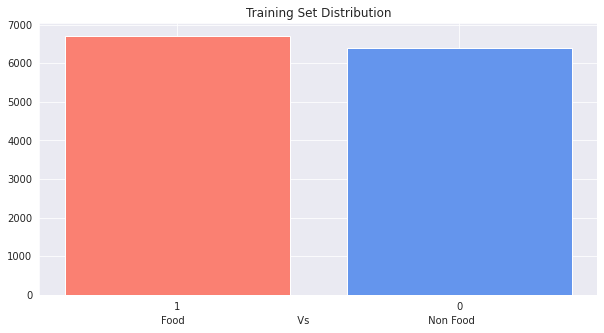

In [ ]:
#Now let's visualize the classes in the training; Here we see that the classes are balanced

plt.figure(figsize=(10,5))
plt.bar(class_id_distribution.index, class_id_distribution.values, color=['salmon','cornflowerblue'])
plt.title(label="Training Set Distribution")
plt.xlabel(('Food                                    Vs                                      Non Food'))
plt.show()       


In [ ]:
#TEST dataset
test = glob.glob('../input/foodnonfood/TEST/TEST/*/*.jpg')
print("Total number of test images: ", len(test))

# make train_image_names as serie object
test = pd.Series(test)
testdf = pd.DataFrame()

# generate Filename field
testdf['Filename'] = test.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
testdf['ClassId'] = test.map(lambda img_name: (img_name.split("/")[-2]))
class_id_distribution2 = testdf['ClassId'].value_counts()
class_id_distribution2

Total number of test images:  3279


1    1678
0    1601
Name: ClassId, dtype: int64

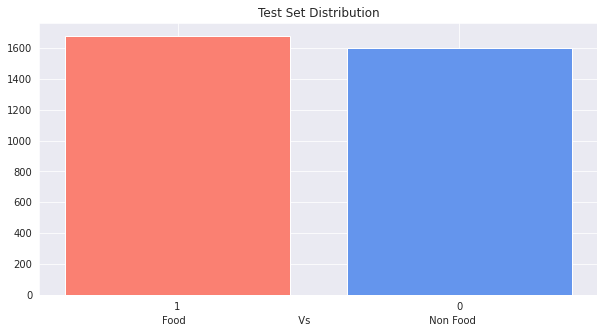

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(class_id_distribution2.index, class_id_distribution2.values, color=['salmon','cornflowerblue'])
plt.title(label="Test Set Distribution")
plt.xlabel(('Food                                    Vs                                      Non Food'))
plt.show()

Now that the data distribution was checked, we saw that the data does not have high bias. Also, our data will be taken in random batches to ensure biasness is not a problem

In [ ]:

#Lets import some ML Libs

from tensorflow import keras #AI interface for TF Lib
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D,BatchNormalization, Flatten #used in DL model layers
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop #to optimize performance
from tensorflow.keras.metrics import categorical_crossentropy #Computes the crossentropy metric between the labels and predictions.
from tensorflow.keras import regularizers # Regularizers for applying penalties on layer parameters during optimization.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #For generating image Batches (with augmentation)
from tensorflow.keras.models import Model, load_model, Sequential #seq to group layer stacks linearly into a Model (tf.keras.Model)
from tensorflow.keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#as all data need to be pre-processed, here Data augmentation is used to produce favourable results
#Augmentation using ImageData Generator
train='../input/foodnonfood/TRAIN/TRAIN'
train_datagen = ImageDataGenerator(
        rescale=1./255, #to transform every pixel value from range [0,255] -> [0,1]
        shear_range=0.2,#shifting the pixels horizontally
        zoom_range=0.2,
        rotation_range=90,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
#a batch size of 32/64 is an optimum size - smaller batches are better for  stability (Brownlee,2019)
#reading the training images
training_set = train_datagen.flow_from_directory(
                    train,
                    target_size=(224, 224),
                    batch_size=64,
                    class_mode='binary')

Found 13113 images belonging to 2 classes.


In [ ]:
#reading test img
test='../input/foodnonfood/TEST/TEST'
test_datagen=ImageDataGenerator(rescale=1./255)
testset=test_datagen.flow_from_directory(test,target_size=(224,224),batch_size=32,class_mode='binary')

Found 3279 images belonging to 2 classes.


Now that the data has been augemented, let's visualise the images in the DS

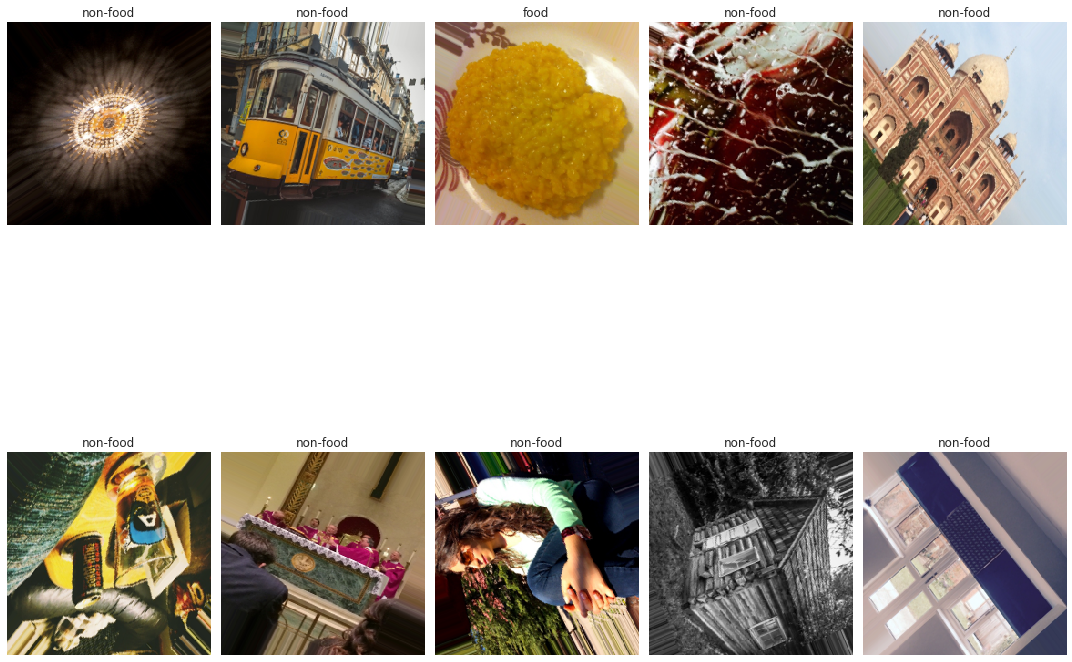

In [ ]:
#First let's visualize the Train set
plt.figure(figsize=(15, 15)) #image displayed in size 15X15
for i in range(0, 10):
    plt.subplot(2, 5, i+1) #2 rows with 5 images per row
    for X_batch, Y_batch in training_set:
        image = X_batch[0]        
        dic = {1:'food', 0:'non-food'} 
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),interpolation='nearest') # nearest will display an image without trying to interpolate between pixels since output display resolution != image resolution
        break
plt.tight_layout()
plt.show()

Images all have different orientation but the image are all of good quality 

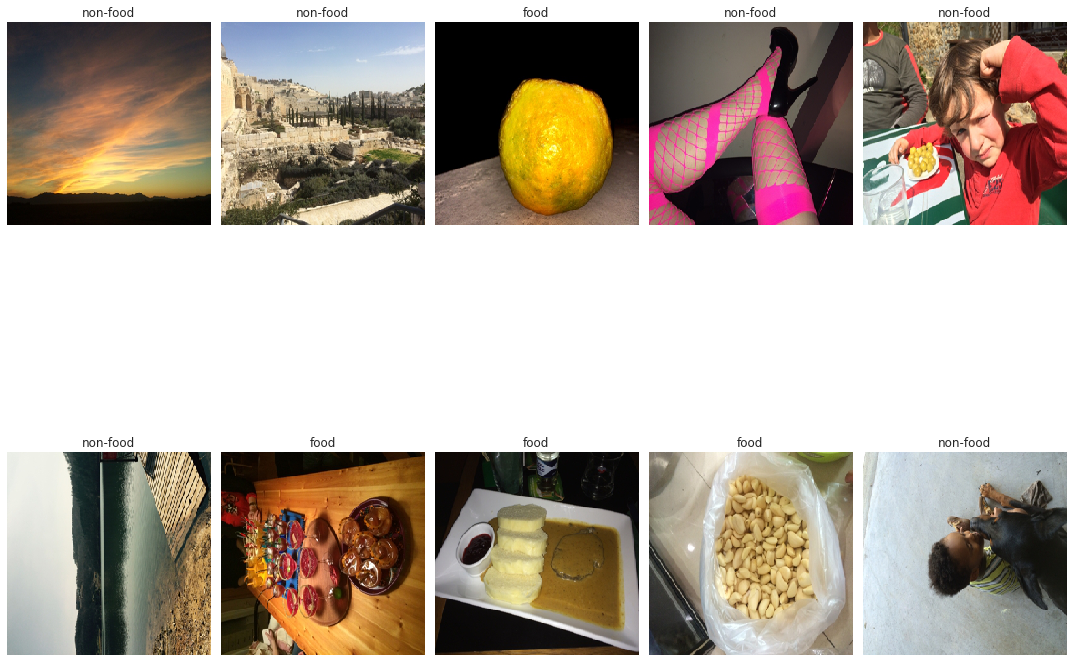

In [ ]:
#Let's visualize the testset

plt.figure(figsize=(15, 15)) #image displayed in size 15X15
for i in range(0, 10):
    plt.subplot(2, 5, i+1) #2 rows with 5 images per row
    for X_batch, Y_batch in testset:
        image = X_batch[0]        
        dic = {1:'food', 0:'non-food'} 
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),interpolation='nearest') # nearest will display an image without trying to interpolate between pixels since output display resolution != image resolution
        break
plt.tight_layout()
plt.show()

In [ ]:
#shape of the sets
print("training set shape is",training_set[-1])
print("test set shape is",testset[-1])

#verifying current image shapes
print("training images shape is",training_set.image_shape)
print("test images shape is",testset.image_shape)

training set shape is (array([], shape=(0, 224, 224, 3), dtype=float32), array([], dtype=float32))
test set shape is (array([], shape=(0, 224, 224, 3), dtype=float32), array([], dtype=float32))
training images shape is (224, 224, 3)
test images shape is (224, 224, 3)


Let's build the model

In [ ]:
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, MaxPooling2D #layers to be used in the CNN arch

In [ ]:
model1= Sequential()
model1.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=[224,224,3]))#images are RGB so last dimension is 3
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model1.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model1.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model1.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
#model1.add(Dropout(0.2))
model1.add(Flatten())#Flattening is No brainer and it simply converts a multi-dimensional object to one-dimensional by re-arranging the elements.
model1.add(Dropout(0.2))
#model1.add(Dense(units=1024,activation='relu'))
model1.add(Dense(units=512,activation='relu'))
model1.add(Dense(units=128,activation='relu'))
model1.add(Dense(units=64,activation='relu'))
model1.add(Dense(units=1,activation='sigmoid')) #only one output required

2022-04-22 00:31:25.740106: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 00:31:25.741053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 00:31:25.741903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 00:31:25.742558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
# Metrics for model
METS = [
      
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
#compiling model
#binary crossentropy used since this is binary classification model; output has only two classes
model1.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy',METS])


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

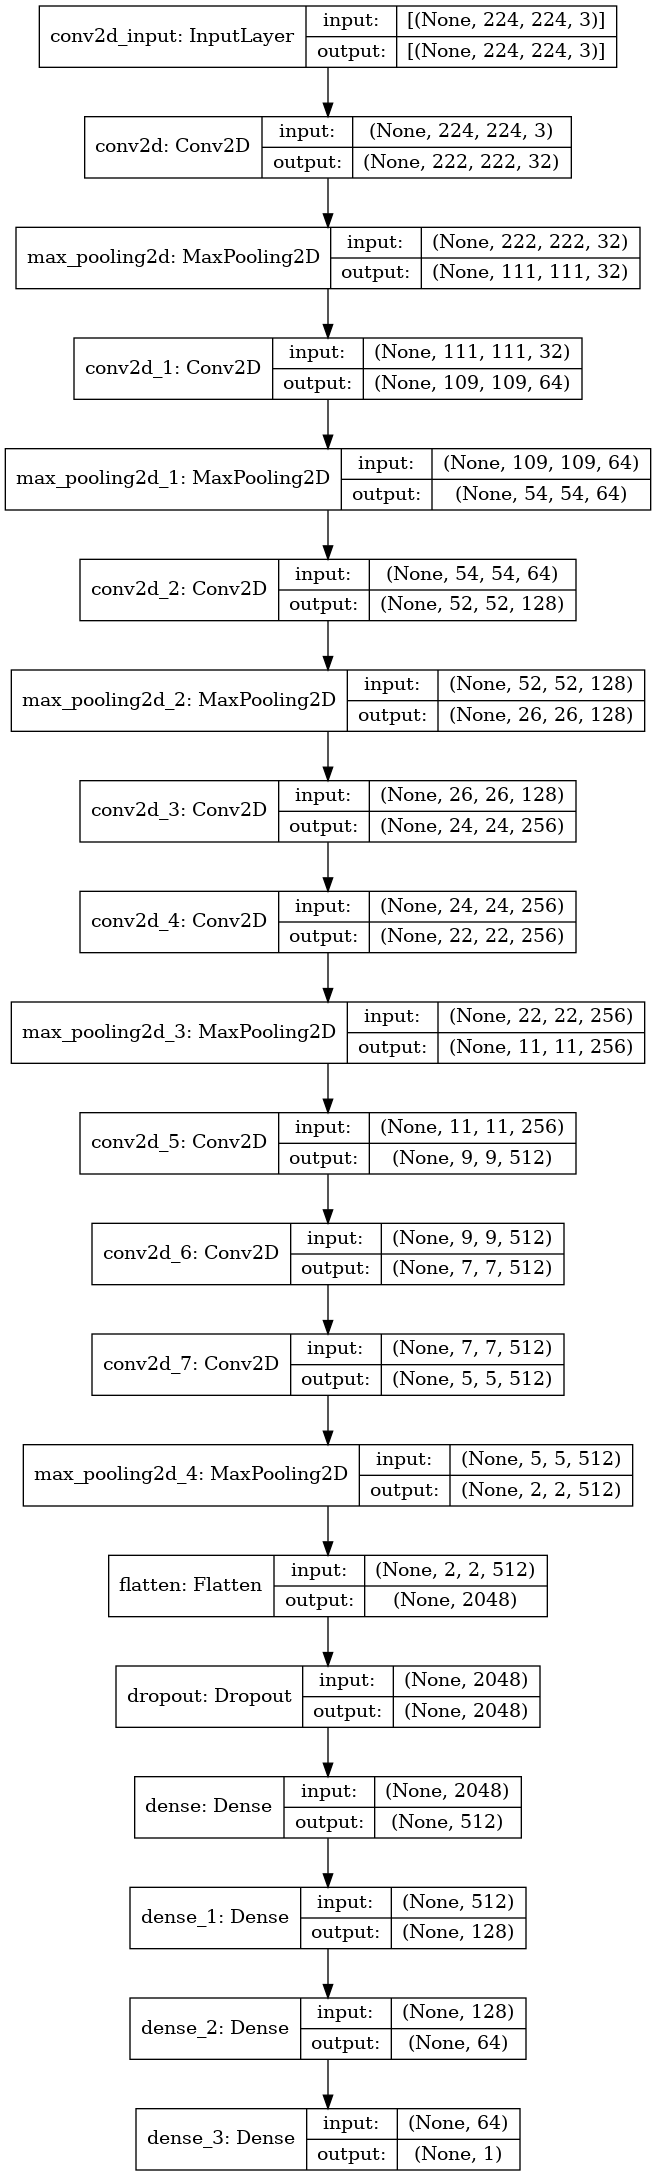

In [ ]:
#model Plotting 
from tensorflow.keras.utils import plot_model
plot_model(model1, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
History = model1.fit(training_set,
                      validation_data=(testset),
                      epochs=25,
                      callbacks=[EarlyStopping(monitor='val_accuracy',patience=10)]) 
#Using early stopping so that if the validation accuracy does not increase 5X conscutively
#model is then stopped; i.e not all 25 epochs will be completed

Epoch 1/25
205/205 [==============================] - 179s 874ms/step - loss: 0.4591 - accuracy: 0.7921 - precision: 0.7930 - recall: 0.8034 - auc: 0.8656 - val_loss: 0.3784 - val_accuracy: 0.8463 - val_precision: 0.8089 - val_recall: 0.9160 - val_auc: 0.9171
Epoch 2/25
205/205 [==============================] - 179s 875ms/step - loss: 0.4424 - accuracy: 0.8029 - precision: 0.8017 - recall: 0.8167 - auc: 0.8756 - val_loss: 0.3779 - val_accuracy: 0.8567 - val_precision: 0.8374 - val_recall: 0.8933 - val_auc: 0.9212
Epoch 3/25
205/205 [==============================] - 180s 880ms/step - loss: 0.4365 - accuracy: 0.8055 - precision: 0.8051 - recall: 0.8177 - auc: 0.8792 - val_loss: 0.4815 - val_accuracy: 0.7655 - val_precision: 0.9284 - val_recall: 0.5870 - val_auc: 0.9218
Epoch 4/25
205/205 [==============================] - 181s 884ms/step - loss: 0.4246 - accuracy: 0.8136 - precision: 0.8146 - recall: 0.8231 - auc: 0.8863 - val_loss: 0.3807 - val_accuracy: 0.8307 - val_precision: 0.8902

In [ ]:
#*others used to catch other output being returned
#evaluation of trained model onto the test set
loss, acc, prec, recall, auc, *others = model1.evaluate(testset) 
acc

103/103 [==============================] - 11s 105ms/step - loss: 0.3253 - accuracy: 0.8557 - precision: 0.9414 - recall: 0.7658 - auc: 0.9572


0.85574871301651

**Let's Plot the iterations for Model 1**

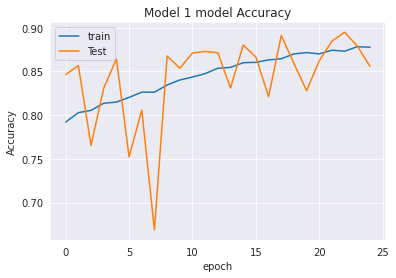

In [ ]:
#Plot Accuracy
plt.figure()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model 1 model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Test'], loc='upper left')
plt.show()

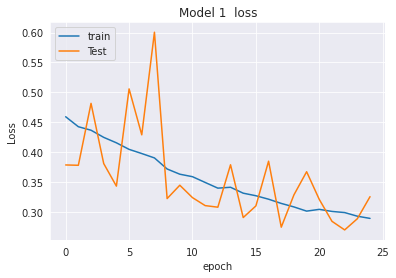

In [ ]:
#Plot LOSS

plt.figure()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model 1  loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Test'], loc='upper left')
plt.show()

Plots end here

Hyper Parameter Tuning


In [ ]:
Tuned= Sequential()#lets make the model more complex to prevent underfit
Tuned.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=[224,224,3],kernel_initializer='he_uniform'))
Tuned.add(MaxPool2D(pool_size=2,strides=2))
Tuned.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
Tuned.add(MaxPool2D(pool_size=2,strides=2))
Tuned.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
Tuned.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
Tuned.add(MaxPool2D(pool_size=2,strides=2))
Tuned.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
Tuned.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
Tuned.add(MaxPool2D(pool_size=2,strides=2))
Tuned.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
Tuned.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
#Tuned.add(MaxPool2D(pool_size=2,strides=2))
Tuned.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
Tuned.add(MaxPool2D(pool_size=2,strides=2))
Tuned.add(Dropout(0.2)) #add dropout to 0.2
Tuned.add(Flatten())
Tuned.add(Dropout(0.2))
Tuned.add(Dense(units=1024,activation='relu'))
Tuned.add(Dense(units=512,activation='relu'))
Tuned.add(Dense(units=128,activation='relu'))
Tuned.add(Dropout(0.2)) 
Tuned.add(Dense(units=64,activation='relu'))
Tuned.add(Dense(units=1,activation='sigmoid')) #only one output required

In [ ]:
#opt = RMSprop(learning_rate= 0.00001, momentum=0.8, epsilon=1e-07)  #changing optimizer & adjust learning rate

Tuned.compile(loss='binary_crossentropy',
              optimizer= 'Adamax',
              metrics=['accuracy',METS])

In [ ]:
Tuned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 128)      

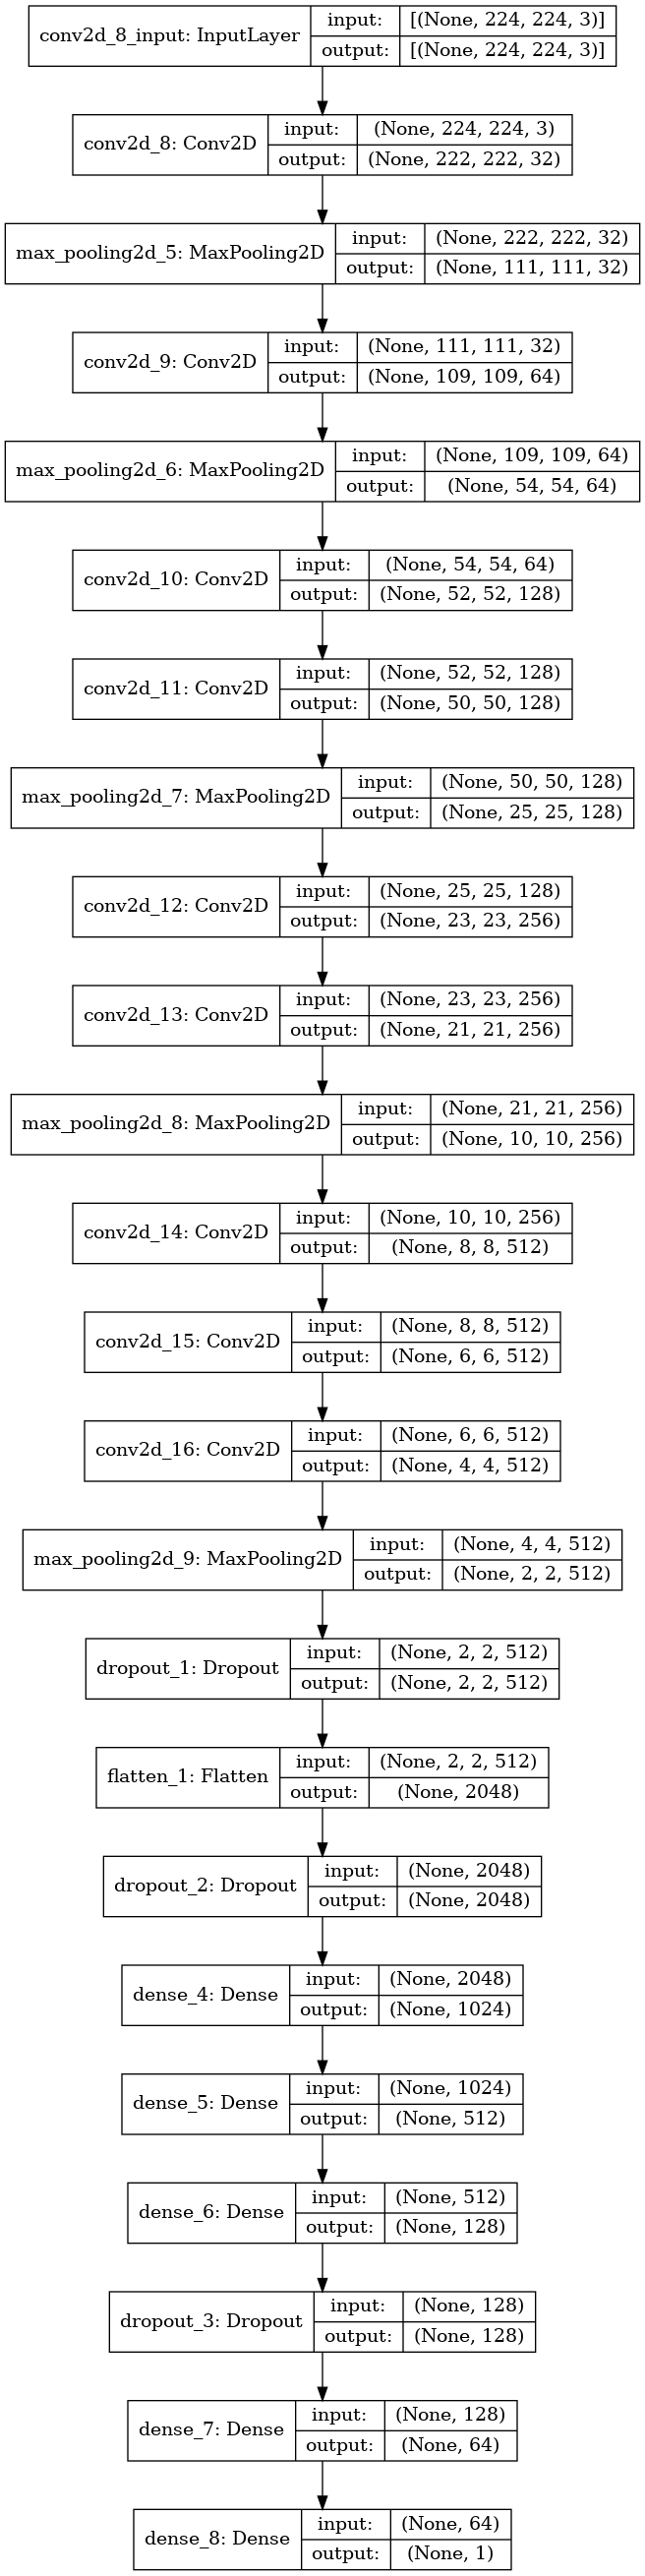

In [ ]:
plot_model(Tuned,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
History2 = Tuned.fit(training_set,
                      validation_data=(testset),
                      epochs=100,#increase iterations
                      callbacks=[EarlyStopping(monitor='val_loss',patience=10)]) 
#Using early stopping so that if the validation accuracy does not increase 10X conscutively
#model is then stopped; i.e not all 100 epochs will be completed

Epoch 1/100
205/205 [==============================] - 180s 880ms/step - loss: 0.4783 - accuracy: 0.7852 - precision: 0.7961 - recall: 0.7798 - auc: 0.8556 - val_loss: 0.3352 - val_accuracy: 0.8649 - val_precision: 0.8325 - val_recall: 0.9213 - val_auc: 0.9354
Epoch 2/100
205/205 [==============================] - 180s 879ms/step - loss: 0.3595 - accuracy: 0.8470 - precision: 0.8553 - recall: 0.8438 - auc: 0.9215 - val_loss: 0.4038 - val_accuracy: 0.7908 - val_precision: 0.9567 - val_recall: 0.6192 - val_auc: 0.9496
Epoch 3/100
205/205 [==============================] - 177s 866ms/step - loss: 0.3099 - accuracy: 0.8703 - precision: 0.8803 - recall: 0.8639 - auc: 0.9418 - val_loss: 0.3248 - val_accuracy: 0.8631 - val_precision: 0.9392 - val_recall: 0.7831 - val_auc: 0.9536
Epoch 4/100
205/205 [==============================] - 182s 887ms/step - loss: 0.2745 - accuracy: 0.8885 - precision: 0.8960 - recall: 0.8848 - auc: 0.9542 - val_loss: 0.2799 - val_accuracy: 0.8902 - val_precision: 0.

In [ ]:
History2 = Tuned.fit(training_set,
                      validation_data=(testset),
                      epochs=100,#increase iterations
                      callbacks=[EarlyStopping(monitor='val_loss',patience=10)]) 

Epoch 1/100
205/205 [==============================] - 186s 906ms/step - loss: 0.1378 - accuracy: 0.9478 - precision: 0.9490 - recall: 0.9490 - auc: 0.9877 - val_loss: 0.2217 - val_accuracy: 0.9158 - val_precision: 0.9564 - val_recall: 0.8754 - val_auc: 0.9777
Epoch 2/100
205/205 [==============================] - 180s 880ms/step - loss: 0.1418 - accuracy: 0.9457 - precision: 0.9493 - recall: 0.9443 - auc: 0.9870 - val_loss: 0.2040 - val_accuracy: 0.9207 - val_precision: 0.9442 - val_recall: 0.8981 - val_auc: 0.9762
Epoch 3/100
205/205 [==============================] - 180s 878ms/step - loss: 0.1373 - accuracy: 0.9472 - precision: 0.9514 - recall: 0.9451 - auc: 0.9878 - val_loss: 0.1666 - val_accuracy: 0.9350 - val_precision: 0.9296 - val_recall: 0.9446 - val_auc: 0.9828
Epoch 4/100
205/205 [==============================] - 181s 881ms/step - loss: 0.1329 - accuracy: 0.9493 - precision: 0.9494 - recall: 0.9516 - auc: 0.9885 - val_loss: 0.2303 - val_accuracy: 0.9180 - val_precision: 0.

TypeError: unsupported operand type(s) for +: 'History' and 'History'

In [ ]:
loss_tuned, acc_tuned, prec_tune,rec_tuned, auc_tuned,*others = Tuned.evaluate(testset) 
acc_tuned

103/103 [==============================] - 11s 107ms/step - loss: 0.1627 - accuracy: 0.9350 - precision: 0.9399 - recall: 0.9327 - auc: 0.9841


0.9350411891937256

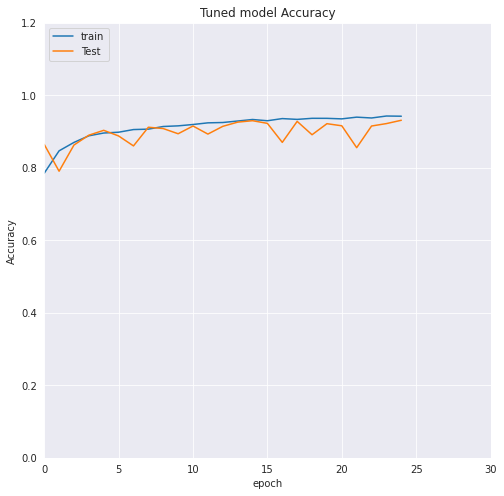

In [ ]:
#Plot Accuracy
plt.figure()
plt.plot(History2.history['accuracy'])
plt.plot(History2.history['val_accuracy'])
plt.title('Tuned model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Test'], loc='upper left')
plt.xlim([0,30])
plt.ylim([0.0,1.2])
plt.show()

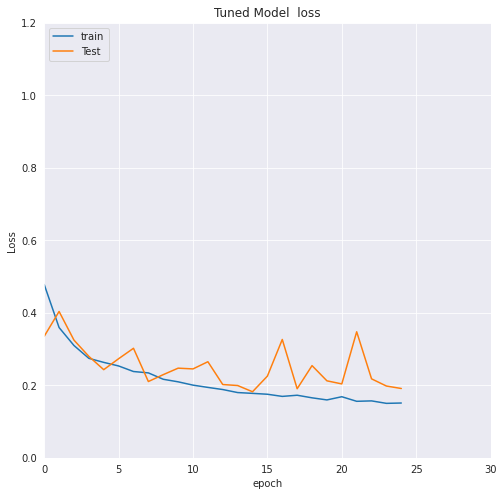

In [ ]:
#Plot LOSS

plt.figure()
plt.plot(History2.history['loss'])
plt.plot(History2.history['val_loss'])
plt.title('Tuned Model  loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Test'], loc='upper left')
plt.xlim([0,30])
plt.ylim([0.0,1.2])
plt.show()

Compare the models

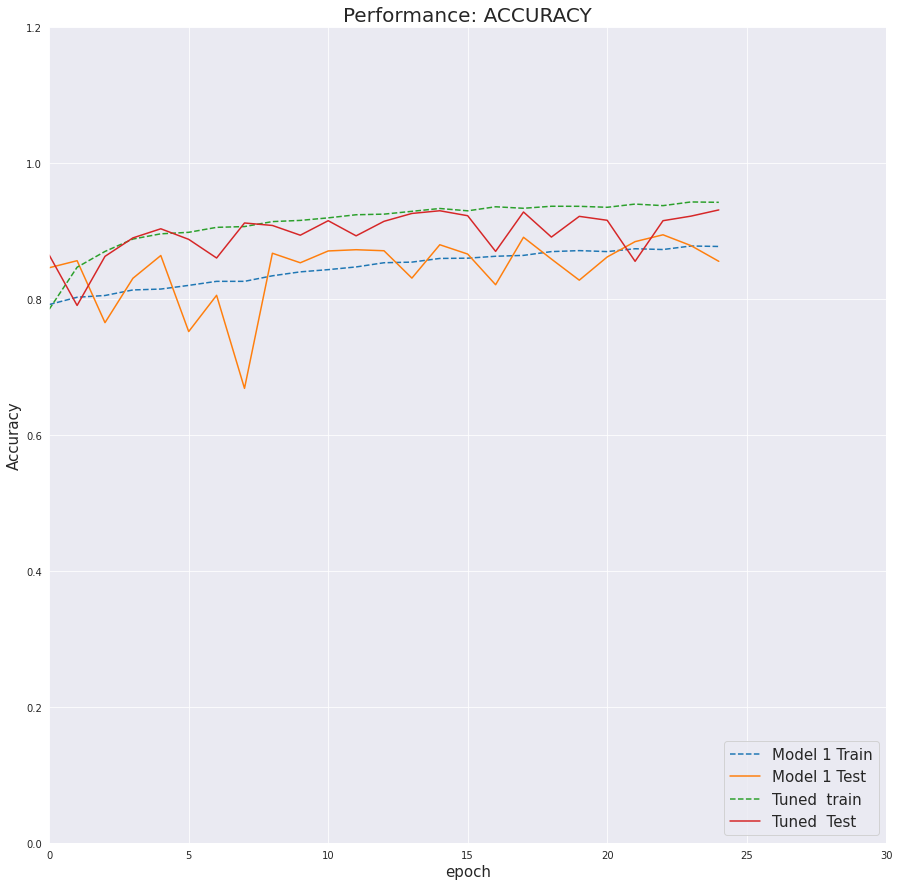

In [ ]:
#ACCURACY Evaluation

plt.figure()
plt.plot(History.history['accuracy'],label='Model 1 Train',linestyle='dashed')
plt.plot(History.history['val_accuracy'],label='Model 1 Test')
plt.plot(History2.history['accuracy'],label='Tuned  train',linestyle='dashed')
plt.plot(History2.history['val_accuracy'],label='Tuned  Test')
plt.title('Performance: ACCURACY',fontsize=20)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend( loc='lower right',fontsize=15)
plt.xlim([0,30])
plt.ylim([0.0,1.2])
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

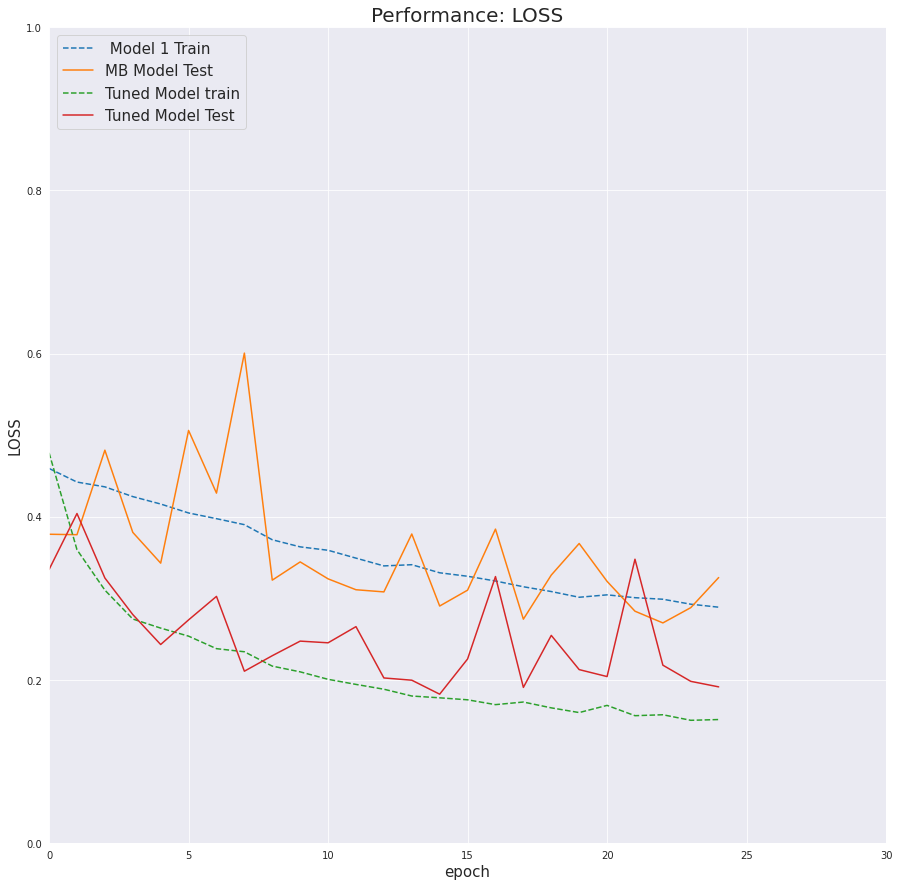

In [ ]:
#LOSS Evaluation

plt.figure()
plt.plot(History.history['loss'],label=' Model 1 Train',linestyle='dashed')
plt.plot(History.history['val_loss'],label='MB Model Test')
plt.plot(History2.history['loss'],label='Tuned Model train',linestyle='dashed')
plt.plot(History2.history['val_loss'],label='Tuned Model Test')
plt.title('Performance: LOSS',fontsize=20)
plt.ylabel('LOSS',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend( loc='upper left',fontsize=15)
plt.xlim([0,30])
plt.ylim([0.0,1.00])
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

Now lets start the predictions

In [ ]:
Prediction=Tuned.predict(testset,verbose=1)

103/103 [==============================] - 10s 99ms/step


View the distribution of predictions

In [ ]:
import scipy
bins = [0.0,0.2,0.4,0.6,0.8,1.0]
mn, std = scipy.stats.norm.fit(Prediction)

In [ ]:
print("Mean of predictions= ",mn)

Mean of predictions=  0.5080594


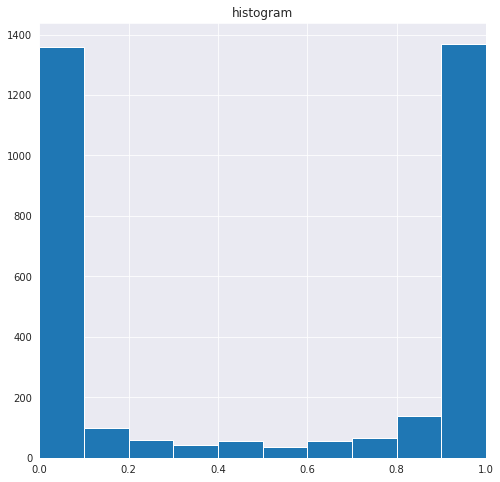

In [ ]:
plt.hist(Prediction,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.title("histogram") 
plt.xlim([0,1])
plt.show()

Lets viz The images and corresponding predictions

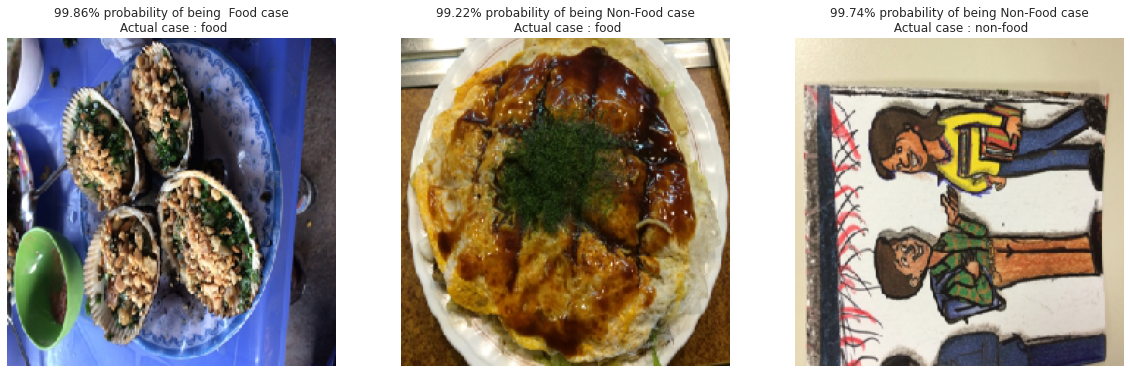

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0+15,3+15):
  plt.subplot(1, 3, (i-15)+1)
  if Prediction[i, 0] >= 0.5: #0.5 can be a good cutoff val based on mean of preds
      out = ('{:.2%} probability of being  Food case'.format(Prediction[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Non-Food case'.format(1-Prediction[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(Y_batch[i]))    
  plt.imshow(np.squeeze(X_batch[i]))
  plt.axis('off')
plt.show()

In [ ]:
testset.reset()
x=np.concatenate([testset.next()[0] for i in range(testset.__len__())])
y=np.concatenate([testset.next()[1] for i in range(testset.__len__())])
print(x.shape)
print(y.shape)

(3279, 224, 224, 3)
(3279,)


In [ ]:
preds = Tuned.predict(testset,verbose=1)

103/103 [==============================] - 11s 104ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
print(classification_report(y_true=y,y_pred=predictions,target_names =['NONFOOD','FOOD']))

              precision    recall  f1-score   support

     NONFOOD       0.93      0.94      0.93      1601
        FOOD       0.94      0.93      0.94      1678

    accuracy                           0.94      3279
   macro avg       0.93      0.94      0.94      3279
weighted avg       0.94      0.94      0.94      3279



<AxesSubplot:>

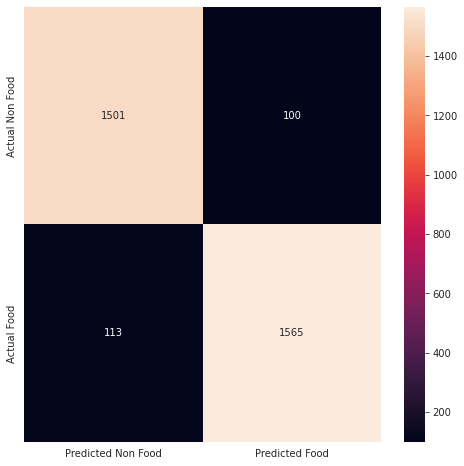

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y, predictions, labels=[0, 1]),index=["Actual Non Food", "Actual Food"],
columns=["Predicted Non Food", "Predicted Food"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
Tuned.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 128)      

In [ ]:
last_layer='conv2d_16'

# GRAD CAM

In [ ]:
from tensorflow.keras.models import Model
import cv2


def GradCam(model, imarr, layer_name, eps=1e-8): #epsil value def
    

    gMod = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
      inputs = tf.cast(imarr, tf.float32)
      (convOutputs, predictions) = gMod(inputs)
      loss = predictions[:, 0]
    gradientss = tape.gradient(loss, convOutputs)
    
    csCNVOut = tf.cast(convOutputs > 0, "float32")
    csgradie = tf.cast(gradientss > 0, "float32")
    guidedgradientss = csCNVOut * csgradie * gradientss
    convOutputs = convOutputs[0]
    guidedgradientss = guidedgradientss[0]
    wgts = tf.reduce_mean(guidedgradientss, axis=(0, 1))
    gdcam = tf.reduce_sum(tf.multiply(wgts, convOutputs), axis=-1)
    (w, h) = (imarr.shape[2], imarr.shape[1])
    hm = cv2.resize(gdcam.numpy(), (w, h))
    numer = hm - np.min(hm)
    denom = (hm.max() - hm.min()) + eps
    hm = numer / denom
    return hm


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def supimp(img_bgr, gdcam, thresh, emphasize=False):
    hm = cv2.resize(gdcam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        hm = sigmoid(hm, 50, thresh, 1)
    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    
    hif = .8
    supimpd_img = hm * hif + img_bgr * hif
    supimpd_img = np.minimum(supimpd_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    supimpd_img_rgb = cv2.cvtColor(supimpd_img, cv2.COLOR_BGR2RGB)
    #supimpd_img_rgb = supimpd_img
    return supimpd_img_rgb

In [ ]:
j=5

In [ ]:
MR=X_batch[j]

In [ ]:
MRre = cv2.resize(MR,(224,224))     # resize image to match model's expected sizing
MRre = np.reshape(MRre,[1,224,224,3]) 

In [ ]:
predtionNF=Tuned.predict(MRre)

Predicted Class is Non-FOOD
Actual Class non-food


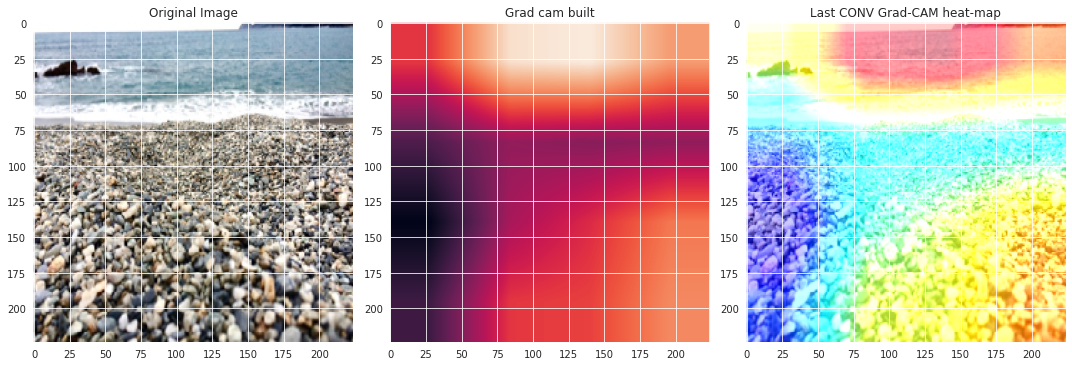

In [ ]:
if (predtionNF>=0.5):
    print('Predicted Class is FOOD')
    print('Actual Class'+dic.get(Y_batch[j]))
    grad_cam3=GradCam(Tuned,MRre,last_layer)
    plt.imsave('./noods.png', MR)
    img_path='./noods.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam3, 1.0, emphasize=False)
    #grad_cam_supimpd3 = supimp(MR, grad_cam3, 0.5, emphasize=False)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam3)
    #plt.axis('off')
    plt.title('Grad cam built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is Non-FOOD')
    print('Actual Class',dic.get(Y_batch[j]))
    grad_cam3=GradCam(Tuned,MRre,last_layer)
    plt.imsave('./mer.png', MR)
    img_path='./mer.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam3, 1.0, emphasize=False)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR)
    #plt.axis('off')
    plt.title('Original Image',)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam3)
    #plt.axis('off')
    plt.title('Grad cam built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
k=3
MR2=X_batch[k]

In [ ]:
MRre2 = cv2.resize(MR2,(224,224))     # resize image to match model's expected sizing
MRre2 = np.reshape(MRre2,[1,224,224,3]) 
predtionNF2=Tuned.predict(MRre2)

Predicted Class is NON FOOD
Actual Class is  non-food


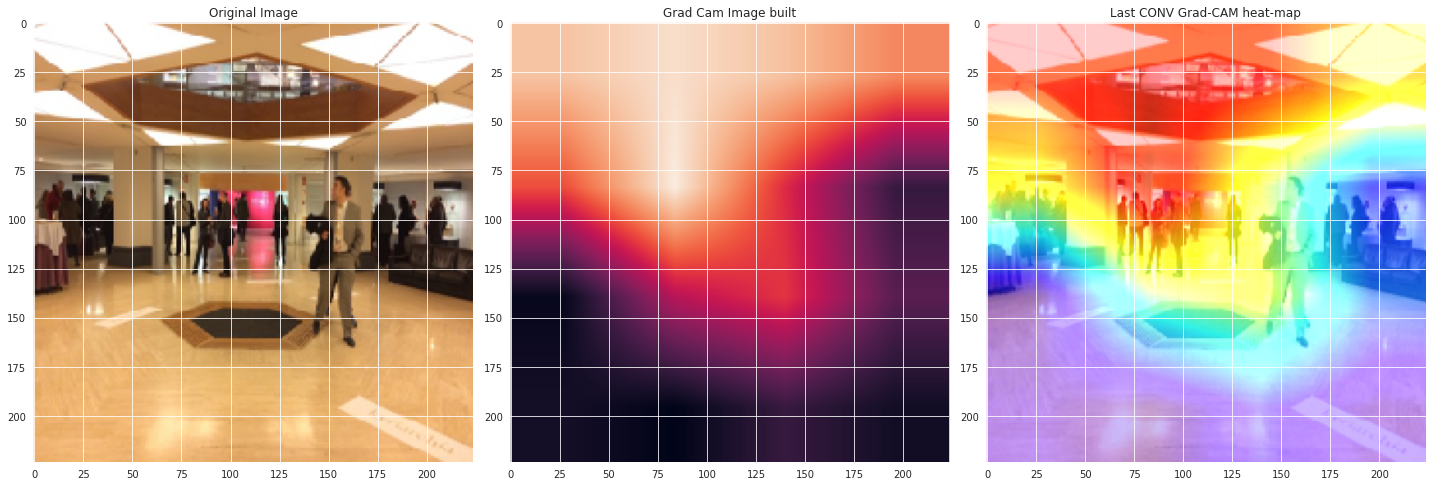

In [ ]:
if (predtionNF2>=0.5):
    print('Predicted Class is FOOD')
    print('Actual Class is ', dic.get(Y_batch[k]))
    grad_cam443=GradCam(Tuned,MRre2,last_layer)
    plt.imsave('./came.png', MR2)
    img_path='./came.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    #grad_cam_supimpd3 = supimp(MR2, grad_cam443, 0.1, emphasize=False)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR2)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is NON FOOD')
    print('Actual Class is ', dic.get(Y_batch[k]))
    grad_cam443=GradCam(Tuned,MRre2,last_layer)
    plt.imsave('./man.png', MR2)
    img_path='./man.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR2)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
k=2
MR2=X_batch[k]

In [ ]:
MRre2 = cv2.resize(MR2,(224,224))     # resize image to match model's expected sizing
MRre2 = np.reshape(MRre2,[1,224,224,3]) 
predtionNF2=Tuned.predict(MRre2)

Predicted Class is FOOD
Actual Class is  food


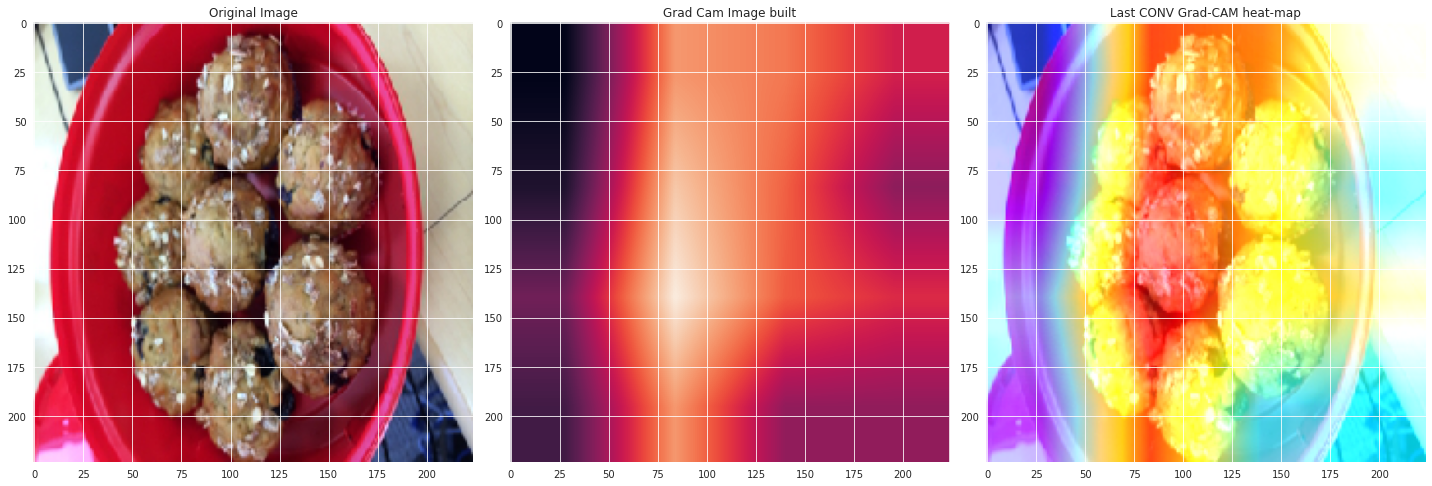

In [ ]:
if (predtionNF2>=0.5):
    print('Predicted Class is FOOD')
    print('Actual Class is ', dic.get(Y_batch[k]))
    grad_cam443=GradCam(Tuned,MRre2,last_layer)
    plt.imsave('./galette.png', MR2)
    img_path='./galette.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR2)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is NON FOOD')
    print('Actual Class is ', dic.get(Y_batch[k]))
    grad_cam443=GradCam(Tuned,MRre2,last_layer)
    plt.imsave('./cheval.png', MR2)
    img_path='./cheval.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    #grad_cam_supimpd3 = supimp(MR2, grad_cam443, 1.5, emphasize=False)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR2)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
FD=12
plt.imshow(X_batch[FD])


In [ ]:
img_array3=X_batch[FD]
img2 = cv2.resize(img_array3,(224,224))     # resize image to match model's expected sizing
img2 = np.reshape(img_array3,[1,224,224,3]) 

In [ ]:
preFD=Tuned.predict(img2)

Predicted Class is NON FOOD
56.69% probability of being NON Food case
Actual Class is  food


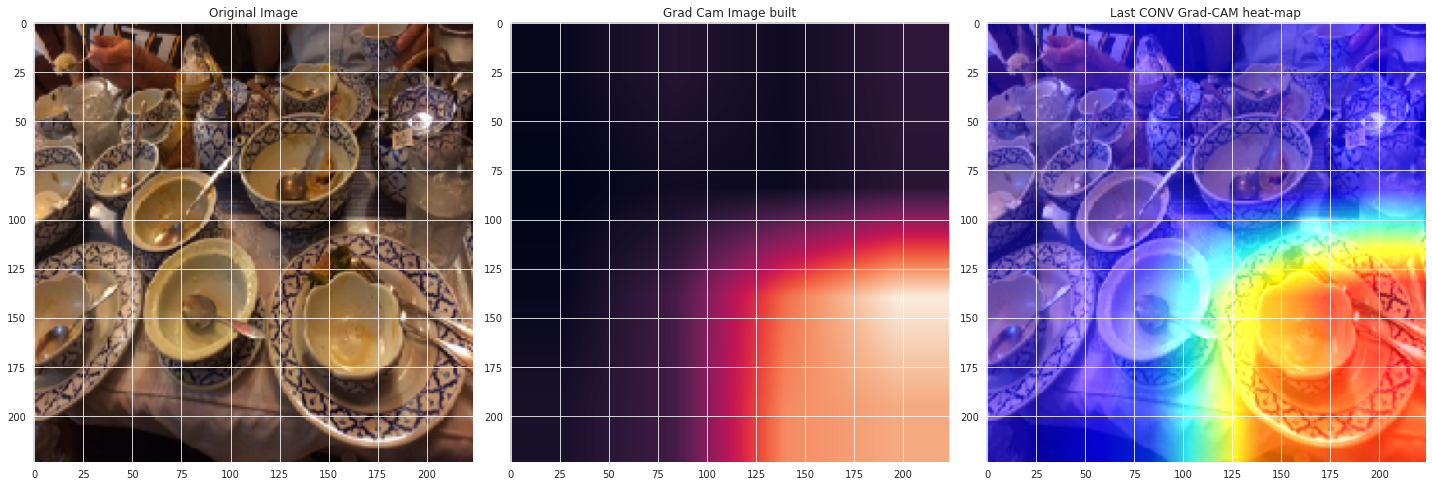

In [ ]:
if (preFD>=0.5):
    print('Predicted Class is FOOD')
    print('{:.2%} probability of being  Food case'.format(preFD[0][0]))
    print('Actual Class is ', dic.get(y[FD]))
    grad_cam443=GradCam(Tuned,img2,last_layer)
    plt.imsave('./cheval.png', MR2)
    img_path='./cheval.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    #grad_cam_supimpd3 = supimp(img_array3, grad_cam443, 0.1, emphasize=False)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img_array3)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is NON FOOD')
    print('{:.2%} probability of being NON Food case'.format(1-preFD[0][0]))
    print('Actual Class is ', dic.get(Y_batch[FD]))
    grad_cam443=GradCam(Tuned,img2,last_layer)
    plt.imsave('./plat.png', img_array3)
    img_path='./plat.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img_array3)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
k=30
MR2=X_batch[k]


MRre2 = cv2.resize(MR2,(224,224))     # resize image to match model's expected sizing
MRre2 = np.reshape(MRre2,[1,224,224,3]) 
predtionNF2=Tuned.predict(MRre2)

Predicted Class is FOOD
Actual Class is  food


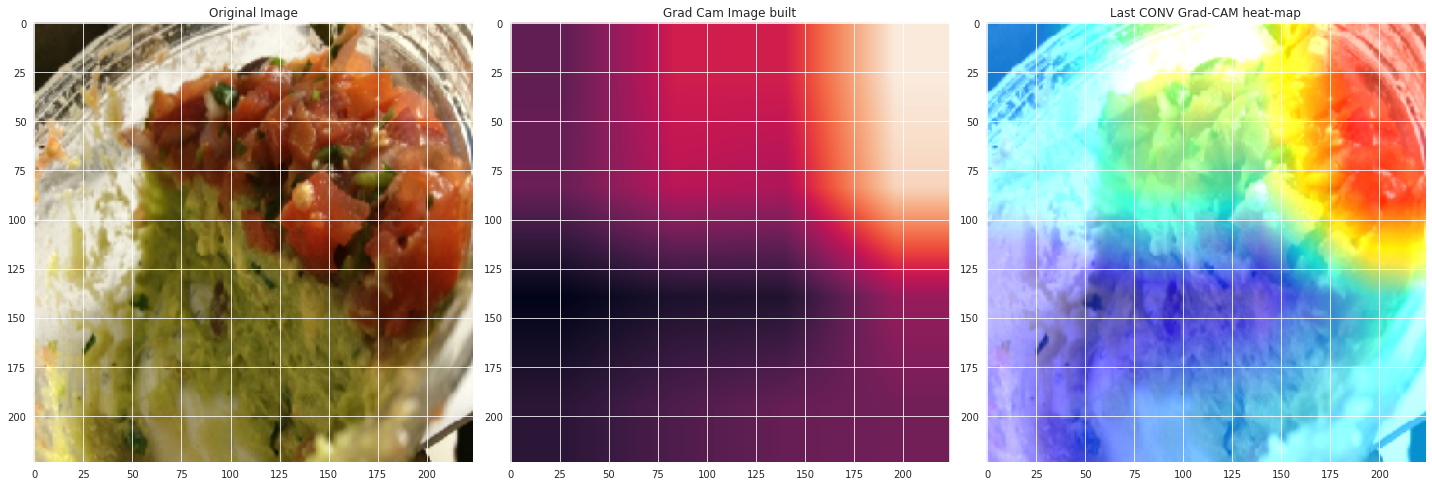

In [ ]:
if (predtionNF2>=0.5):
    print('Predicted Class is FOOD')
    print('Actual Class is ', dic.get(Y_batch[k]))
    grad_cam443=GradCam(Tuned,MRre2,last_layer)
    plt.imsave('./pottage.png', MR2)
    img_path='./pottage.png'
    #display(Image.open(img_path))
    #grad_cam443=GradCam(Tuned,MRre2,last_layer)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR2)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is NON FOOD')
    print('Actual Class is ', dic.get(Y_batch[k]))
    grad_cam443=GradCam(Tuned,MRre2,last_layer)
    plt.imsave('./Ciel.png', MR2)
    img_path='./Ciel.png'
    #display(Image.open(img_path))
    #grad_cam443=GradCam(Tuned,MRre2,last_layer)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(MR2)
    #plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    #plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    #plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
NFD=27
plt.imshow(X_batch[NFD])


In [ ]:
img_array4=X_batch[NFD]
img3 = cv2.resize(img_array4,(224,224))     # resize image to match model's expected sizing
img3 = np.reshape(img_array4,[1,224,224,3]) 

In [ ]:
preNFD=Tuned.predict(img3)

Predicted Class is FOOD
99.51% probability of being  Food case
Actual Class is  food


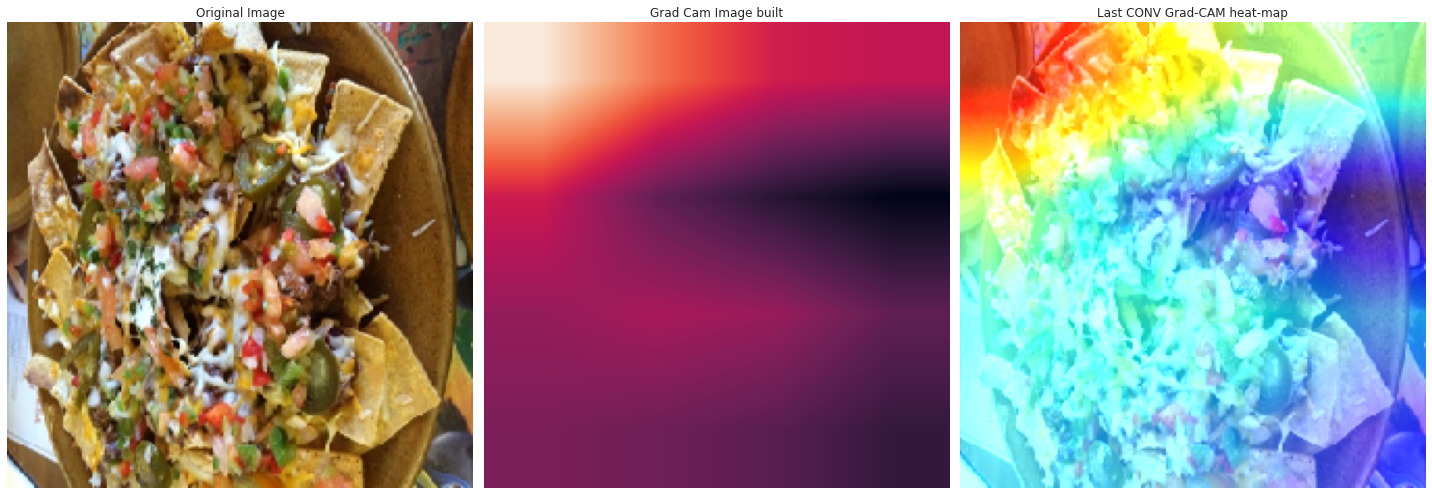

In [ ]:
if (preNFD>=0.5):
    print('Predicted Class is FOOD')
    print('{:.2%} probability of being  Food case'.format(preNFD[0][0]))
    print('Actual Class is ', dic.get(Y_batch[NFD]))
    grad_cam443=GradCam(Tuned,img3,last_layer)
    plt.imsave('./cafe.png', img_array4)
    img_path=('./cafe.png')
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    #grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img_array4)
    plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is NON FOOD')
    print('{:.2%} probability of being NON Food case'.format(1-preNFD[0][0]))
    print('Actual Class is ', dic.get(y[NFD]))
   
    grad_cam443=GradCam(Tuned,img3,last_layer)
    plt.imsave('./paintin.png', img_array4)
    img_path=('./paintin.png')
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img_array4)
    plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
print("END")

END


Text(0.5, 1.0, 'non-food')

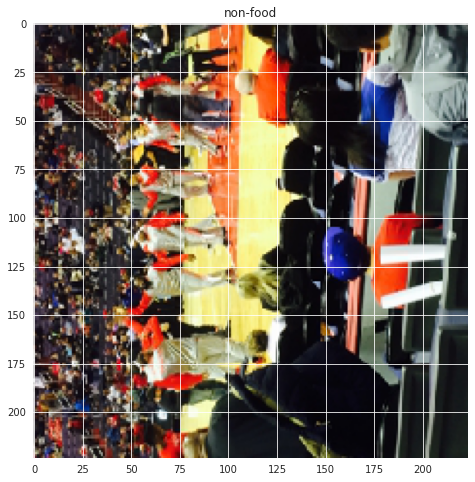

In [ ]:
NFD=4
plt.imshow(X_batch[NFD])
plt.title(dic.get(Y_batch[NFD]))

In [ ]:
img_array4=X_batch[NFD]
img3 = cv2.resize(img_array4,(224,224))     # resize image to match model's expected sizing
img3 = np.reshape(img_array4,[1,224,224,3]) 

In [ ]:
preNFD=Tuned.predict(img3)

Predicted Class is NON FOOD
96.71% probability of being NON Food case
Actual Class is  non-food


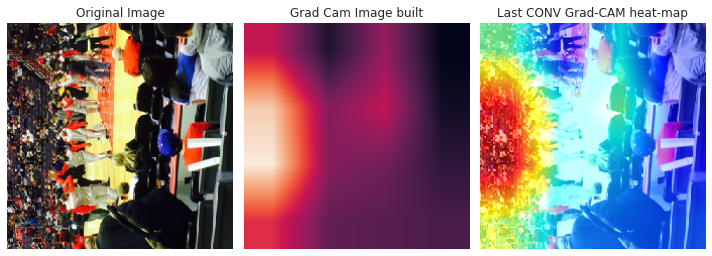

In [ ]:
if (preNFD>=0.5):
    print('Predicted Class is FOOD')
    print('{:.2%} probability of being  Food case'.format(preNFD[0][0]))
    print('Actual Class is ', dic.get(Y_batch[NFD]))
    grad_cam443=GradCam(Tuned,img3,last_layer)
    plt.imsave('./cafe.png', img_array4)
    img_path=('./cafe.png')
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    #grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img_array4)
    plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()
else:
    print('Predicted Class is NON FOOD')
    print('{:.2%} probability of being NON Food case'.format(1-preNFD[0][0]))
    print('Actual Class is ', dic.get(y[NFD]))
    grad_cam443=GradCam(Tuned,img3,last_layer)
    rad_cam443=GradCam(Tuned,img3,last_layer)
    plt.imsave('./ball.png', img_array4)
    img_path=('./ball.png')
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224),3)
    grad_cam_supimpd3 = supimp(img, grad_cam443, 1.0, emphasize=False)
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img_array4)
    plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grad_cam443)
    plt.axis('off')
    plt.title('Grad Cam Image built')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(grad_cam_supimpd3)
    plt.axis('off')
    plt.title('Last CONV Grad-CAM heat-map')
    plt.tight_layout()

In [ ]:
#THE END